In [1]:
# package imports

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

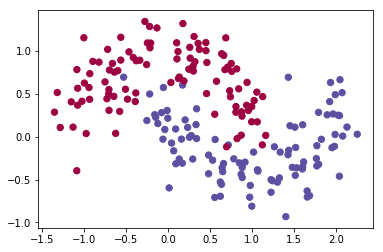

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)

In [3]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X,y)

/root/installation/miniconda3/envs/sql_nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [4]:
# Helper function to plot a decision boundary.

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5, 1.0, 'Logistic Regression')

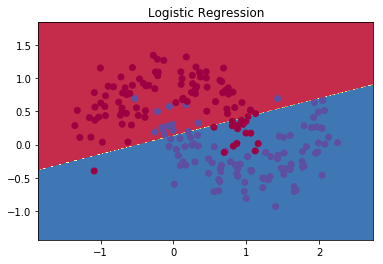

In [5]:
# plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters - Picked by hand
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let's implement the loss function we defined. We use this to evaluate how well our model is doing.

In [8]:
def softmax(z2):
    exp_scores = np.exp(z2)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [16]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    y_hat = softmax(z2)
    # Calculating the loss
    correct_logprobs = -np.log(y_hat[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability

In [10]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    y_hat = softmax(z2)
    return np.argmax(y_hat, axis=1)

Finally, here comes the function to our neural network it implements batch gradient descent using the backpropagation derivates we found above

In [14]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer.
# - num_passes: Number of passes through the training data for gradient descent.
# - print_loss: If True, print the loss every 1000 iterations.

def build_model(nn_hdim, num_passes=20000, print_loss=False):
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch..
    for i in range(0, num_passes):
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        y_hat = softmax(z2)
        
        # Backpropagation
        delta3 = y_hat
        delta3[range(num_examples), y] -= 1
        
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 == reg_lambda * W1
        
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss aftrer iteration %i: %f" % (i, calculate_loss(model)))
            
    return model

Loss aftrer iteration 0: 0.432382
Loss aftrer iteration 1000: 0.068988
Loss aftrer iteration 2000: 0.070682
Loss aftrer iteration 3000: 0.070680
Loss aftrer iteration 4000: 0.070720
Loss aftrer iteration 5000: 0.070755
Loss aftrer iteration 6000: 0.070780
Loss aftrer iteration 7000: 0.070799
Loss aftrer iteration 8000: 0.070813
Loss aftrer iteration 9000: 0.070823
Loss aftrer iteration 10000: 0.070830
Loss aftrer iteration 11000: 0.070836
Loss aftrer iteration 12000: 0.070841
Loss aftrer iteration 13000: 0.070845
Loss aftrer iteration 14000: 0.070848
Loss aftrer iteration 15000: 0.070850
Loss aftrer iteration 16000: 0.070852
Loss aftrer iteration 17000: 0.070854
Loss aftrer iteration 18000: 0.070856
Loss aftrer iteration 19000: 0.070857


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

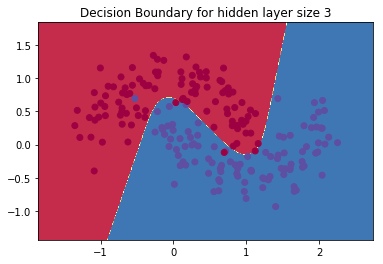

In [15]:
model = build_model(3, print_loss=True)

plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")